In [1]:
import pandas as pd

In [2]:
df = pd.read_csv("train.csv")[:1000]

In [3]:
import ast
import json

# Function to safely parse the string as a list
def parse_list_string(s):
    try:
        # First try to parse as JSON
        return json.loads(s)
    except:
        try:
            # Then try to parse as Python literal
            return ast.literal_eval(s)
        except:
            # If all fails, return as is
            return [s]

# Create a new dataframe to store the expanded data
expanded_rows = []

for _, row in df.iterrows():
    # Parse the prompts and responses
    prompts = parse_list_string(row['prompt'])
    responses_a = parse_list_string(row['response_a'])
    responses_b = parse_list_string(row['response_b'])
    
    # Make sure all lists have the same length
    max_len = max(len(prompts), len(responses_a), len(responses_b))
    prompts = prompts + [''] * (max_len - len(prompts))
    responses_a = responses_a + [''] * (max_len - len(responses_a))
    responses_b = responses_b + [''] * (max_len - len(responses_b))
    
    # Create a new row for each prompt-response pair
    for i in range(max_len):
        expanded_rows.append({
            'id': row['id'],
            'model_a': row['model_a'],
            'model_b': row['model_b'],
            'prompt': prompts[i],
            'response_a': responses_a[i],
            'response_b': responses_b[i],
            'winner_model_a': row['winner_model_a'],
            'winner_model_b': row['winner_model_b'],
            'winner_tie': row['winner_tie']
        })

# Create the expanded dataframe
expanded_df = pd.DataFrame(expanded_rows)

# Display the first few rows of the expanded dataframe
expanded_df.head()

,id,model_a,model_b,prompt,response_a,response_b,winner_model_a,winner_model_b,winner_tie
0,30192,gpt-4-1106-preview,gpt-4-0613,Is it morally right to try to have a certain p...,The question of whether it is morally right to...,"As an AI, I don't have personal beliefs or opi...",1,0,0
1,30192,gpt-4-1106-preview,gpt-4-0613,"OK, does pineapple belong on a pizza? Relax an...","Ah, the age-old culinary conundrum that has di...","As an AI, I don't eat, so I don't have persona...",1,0,0
2,53567,koala-13b,gpt-4-0613,What is the difference between marriage licens...,A marriage license is a legal document that al...,A marriage license and a marriage certificate ...,0,1,0
3,53567,koala-13b,gpt-4-0613,How can I get both of them as quick as possibl...,If you want to get both a marriage license and...,"In California, here are the general steps to o...",0,1,0
4,53567,koala-13b,gpt-4-0613,What is the minimal time to get them? 1 day or...,The minimal time to get a marriage license and...,The marriage license in California is issued i...,0,1,0


In [4]:
filtered_df = expanded_df[expanded_df['winner_tie'] == 0]
print(f"Original shape: {expanded_df.shape}")
print(f"After removing ties: {filtered_df.shape}")
print(filtered_df[['winner_model_a', 'winner_model_b']].value_counts())

Original shape: (1245, 9)
After removing ties: (895, 9)
winner_model_a  winner_model_b
0               1                 456
1               0                 439
Name: count, dtype: int64


In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
# Step 1: Install sentence-transformers if needed
# !pip install sentence-transformers

# Step 2: Import and load the SBERT model
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('all-MiniLM-L6-v2')  # Lightweight model, good balance of speed/performance

# Step 3: Prepare text pairs
# Check for NaN values
print("NaN values in prompt:", filtered_df['prompt'].isna().sum())
print("NaN values in response_a:", filtered_df['response_a'].isna().sum())
print("NaN values in response_b:", filtered_df['response_b'].isna().sum())

# Convert all to strings and handle NaN values
filtered_df['prompt_resp_a'] = filtered_df['prompt'].fillna('').astype(str) + " " + filtered_df['response_a'].fillna('').astype(str)
filtered_df['prompt_resp_b'] = filtered_df['prompt'].fillna('').astype(str) + " " + filtered_df['response_b'].fillna('').astype(str)

# Now encode
embeddings_a = model.encode(filtered_df['prompt_resp_a'].tolist(), show_progress_bar=True)
embeddings_b = model.encode(filtered_df['prompt_resp_b'].tolist(), show_progress_bar=True)

# Step 5: Create feature vectors (multiple approaches)
# Approach 1: Concatenate embeddings
X_concat = np.hstack([embeddings_a, embeddings_b])

# Approach 2: Calculate the difference between embeddings
X_diff = embeddings_a - embeddings_b

# Approach 3: Calculate absolute difference (may capture similarity better)
X_abs_diff = np.abs(embeddings_a - embeddings_b)

# Choose which approach to use
X = X_abs_diff  # or X_diff or X_abs_diff
y = filtered_df['winner_model_a']

print(f"Feature matrix shape: {X.shape}")

C:\Users\justi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\torch\utils\_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(



NaN values in prompt: 0
NaN values in response_a: 2
NaN values in response_b: 1


C:\Users\justi\AppData\Local\Temp\ipykernel_4508\2811217388.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['prompt_resp_a'] = filtered_df['prompt'].fillna('').astype(str) + " " + filtered_df['response_a'].fillna('').astype(str)
C:\Users\justi\AppData\Local\Temp\ipykernel_4508\2811217388.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['prompt_resp_b'] = filtered_df['prompt'].fillna('').astype(str) + " " + filtered_df['response_b'].fillna('').astype(str)


Batches:   0%|          | 0/28 [00:00<?, ?it/s]

Batches:   0%|          | 0/28 [00:00<?, ?it/s]

Feature matrix shape: (895, 768)


In [7]:
# Step 3: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print(f"Training data shape: {X_train.shape}")
print(f"Testing data shape: {X_test.shape}")

Training data shape: (626, 768)
Testing data shape: (269, 768)


In [8]:
# Step 4: Create and train the Logistic Regression model (replacing Random Forest)
# Initialize the model
# C parameter controls regularization strength (smaller values = stronger regularization)
# max_iter increases the maximum number of iterations for convergence
log_reg_model = LogisticRegression(C=1.0, max_iter=1000, random_state=42, solver='liblinear')

# Train the model
log_reg_model.fit(X_train, y_train)

print("Model training complete")

Model training complete


Accuracy: 0.5651

Classification Report:
              precision    recall  f1-score   support

           0       0.58      0.55      0.57       139
           1       0.55      0.58      0.57       130

    accuracy                           0.57       269
   macro avg       0.57      0.57      0.57       269
weighted avg       0.57      0.57      0.57       269



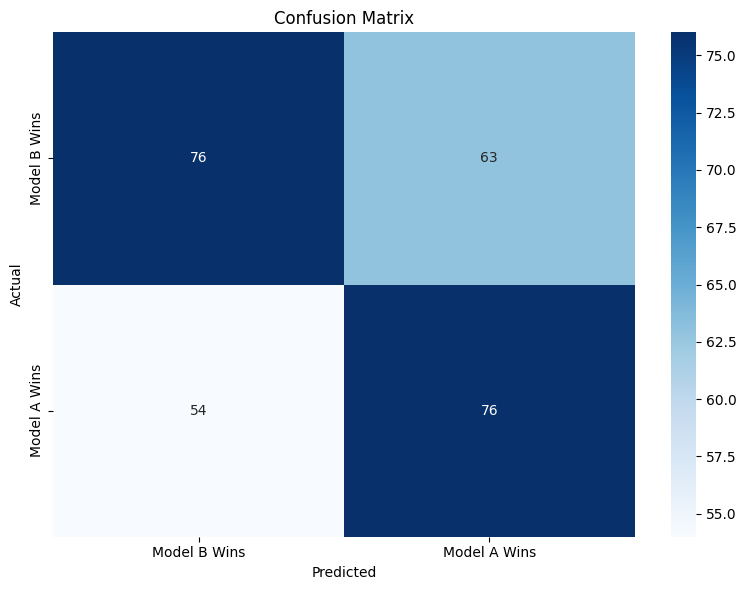

In [9]:
# Step 5: Make predictions and evaluate the model
# Predict on test data
y_pred = log_reg_model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Model B Wins', 'Model A Wins'],
            yticklabels=['Model B Wins', 'Model A Wins'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()